In [1]:
%matplotlib notebook
from __future__ import division

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from matplotlib.pyplot import plot, ylabel, xlabel, yscale, xscale, legend, subplots, gca, gcf
from matplotlib.ticker import FormatStrFormatter
from theano import function
import numpy as np
import gzip
import cPickle
from scipy.optimize import minimize
from climin.util import optimizer
from itertools import repeat, cycle, islice, izip
import random
inf = float("inf")

gnumpy: failed to import cudamat. Using npmat instead. No GPU will be used.


In [3]:
from breze.learn.data import one_hot
from breze.learn.base import cast_array_to_local_type
from schlichtanders.myfunctools import compose, meanmap, summap, compose_fmap, Average
from schlichtanders import myfunctools
from schlichtanders.mygenerators import eatN, chunk, chunk_list, every, takeN
from schlichtanders.myplot import add_val, add_point

In [4]:
from theano_models import (Merge, Flatten, Reparameterize, reduce_all_identities,
                           inputting_references, outputting_references)
from theano_models.tools import (as_tensor_variable, total_size, clone, clone_all,PooledRandomStreams,
                                 get_profile, squareplus, squareplus_inv, softplus, softplus_inv)
from theano_models.visualization import d3viz
from IPython.display import IFrame
import theano_models.deterministic_models as dm
import theano_models.probabilistic_models as pm
import theano_models.extra_models as em
import theano_models.postmaps as post
from theano_models.composing import normalizing_flow, variational_bayes
from theano_models import data

In [5]:
from sklearn import cross_validation
import theano
import theano.tensor as T
from theano.printing import debugprint
from theano.tensor.shared_randomstreams import RandomStreams

In [6]:
from sqlalchemy import Column, Integer, Unicode, UnicodeText, String, PickleType, Float, Boolean
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base

In [7]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [8]:
inputting_references.update(['to_be_randomized'])
inputting_references, outputting_references

({'flat',
  'inputs',
  'n_data',
  'noise',
  'parameters',
  'parameters_positive',
  'parameters_psumto1',
  'to_be_randomized'},
 {'kl_prior', 'logP', 'loglikelihood', 'norm_det', 'outputs'})

In [9]:
from schlichtanders.myobjects import NestedNamespace

In [10]:
pm.RNG = NestedNamespace(PooledRandomStreams(pool_size=int(5e8)), RandomStreams())

# Data

    # datasetnames = ["boston", "concrete", "energy", "kin8nm", "naval", "powerplant", "protein", "winered", "yacht", "year"]
    datasetnames = ["boston", "concrete", "energy", "kin8nm", "naval", "powerplant", "winered", "yacht"]

In [11]:
datasetname = "concrete"

In [12]:
Z, X = getattr(data, "_" + datasetname)()
# normalization is standard in Probabilistic Backpropagation Paper
X_mean = X.mean(0)
X_std = X.std(0)
X = (X - X_mean) / X_std
Z_mean = Z.mean(0)
Z_std = Z.std(0)
Z = (Z - Z_mean) / Z_std

In [13]:
X, TX, Z, TZ = cross_validation.train_test_split(X, Z, test_size=0.1) # 10% test used in paper
X, VX, Z, VZ = cross_validation.train_test_split(X, Z, test_size=0.1) # 20% validation used in paper

# Hyperparameters

In [14]:
engine = create_engine('sqlite:///hyperparameters_several.db')
Base = declarative_base(bind=engine)

class RandomHyper(Base):
    __tablename__ = datasetname
    id = Column(Integer, primary_key=True)
    
    # hyper parameters:
    datasetname = Column(String)
    n_epochs = Column(Integer)
    average_n = Column(Integer)
    units_per_layer = Column(Integer)
    minus_log_s = Column(Integer)
    batch_size = Column(Integer)
    
    n_normflows = Column(Integer)
    
    opt_identifier = Column(String)
    opt_momentum = Column(Float)
    opt_offset = Column(Float)
    opt_decay = Column(Float)
    opt_step_rate = Column(Float)
    
    # results:
    best_val_loss = Column(Float)
    best_parameters = Column(PickleType, nullable=True)
    train_loss = Column(PickleType)
    val_loss = Column(PickleType)

    def __init__(self):
        self.datasetname = datasetname
        # hyper parameters:
        self.n_epochs = 200
        self.batch_size = 100
        self.average_n = 1
        self.units_per_layer = 50
        self.minus_log_s = random.choice([1,2,3,4,5,6,7])
        # the prior is learned together with the other models in analogy to the paper Probabilistic Backpropagation
        
        self.n_normflows = random.choice([1,2,3,4,8,32])
        
        self.opt_identifier = random.choice(["adadelta", "adam", "rmsprop"])
        if self.opt_identifier == "adadelta":
            self.opt_momentum = random.choice([np.random.uniform(0, 0.01), np.random.uniform(0.9, 1)])
            self.opt_offset = random.choice([5e-5, 1e-8])
            self.opt_step_rate = random.choice([1, 1e-3, 1e-4, 1e-5])
        elif self.opt_identifier == "adam":
            self.opt_momentum = random.choice([np.random.uniform(0, 0.01), np.random.uniform(0.8, 0.93)])
            self.opt_offset = 10 ** -np.random.uniform(3, 4)
            self.opt_step_rate = random.choice([1e-3, 1e-4, 1e-5])
        elif self.opt_identifier == "rmsprop":
            self.opt_momentum = random.choice([np.random.uniform(0.002, 0.008), np.random.uniform(0.9, 1)])
            self.opt_offset = np.random.uniform(0, 0.000045)
            self.opt_step_rate = random.choice([1e-3, 1e-4, 1e-5])
        self.opt_decay = np.random.uniform(0.78, 1)
        
        self.init_results()
    
    def init_results(self):
        # extra for being able to reset results for loaded hyperparameters
        self.best_parameters = None
        self.best_val_loss = inf
        self.train_loss = []
        self.val_loss = []

Base.metadata.create_all()
Session = sessionmaker(bind=engine)
sql_session = Session()
hyper = RandomHyper()
hyper.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fcba8e6d910>,
 'average_n': 1,
 'best_parameters': None,
 'best_val_loss': inf,
 'datasetname': 'concrete',
 'minus_log_s': 6,
 'n_epochs': 100,
 'n_normflows': 3,
 'opt_decay': 0.8576338038637985,
 'opt_identifier': 'adadelta',
 'opt_momentum': 0.006865420271401792,
 'opt_offset': 1e-08,
 'opt_step_rate': 1,
 'train_loss': [],
 'units_per_layer': 50,
 'val_loss': []}

# Model

## data modelling

In [15]:
# this is extremely useful to tell everything the default sizes
input = as_tensor_variable(X[0], name="X")

In [16]:
predictor = dm.Mlp(
    input=input,
    output_size=Z.shape[1],
    output_transfer='identity',
    hidden_sizes=[hyper.units_per_layer]*1,
    hidden_transfers=["rectifier"]*1
)
predictor

Mlp { 'inputs': [X],
  'outputs': AffineNonlinear2.outputs,
  'parameters': [weights, bias, weights2, bias2]}

In [17]:
target_distribution = pm.DiagGaussianNoise(predictor)
target_distribution

DiagGaussianNoise { 'inputs': [AffineNonlinear2.outputs],
  'logP': <FunctionWrapper at 0x7fcba7f85bb0 for function at 0x7fcba7fbc5f0>,
  'noise': [DiagGaussianNoise.noise.0],
  'outputs': DiagGaussianNoise.outputs,
  'parameters': [],
  'parameters_positive': [var]}

In [18]:
targets = Merge(target_distribution, predictor, Flatten(predictor['parameters'], flat_key="to_be_randomized"))
targets

Merge { 'inputs': [X],
  'logP': <FunctionWrapper at 0x7fcba7f85bb0 for function at 0x7fcba7fbc5f0>,
  'noise': [DiagGaussianNoise.noise.0],
  'outputs': DiagGaussianNoise.outputs,
  'parameters': [],
  'parameters_positive': [var],
  'to_be_randomized': "weights:bias:weights2:bias2"}

## parameter modelling

In [19]:
params_base = pm.Gauss(output_size=total_size(targets['to_be_randomized']))  
# if you want to use size directly, CAUTION, you need to copy before!
# params_base.map('parameters_positive', reparameterize_map(squareplus, squareplus_inv), 'parameters')
params_base

Gauss { 'inputs': [],
  'logP': <FunctionWrapper at 0x7fcba25020c0 for function at 0x7fcba24f4c80>,
  'noise': [GaussianNoise.noise.0],
  'outputs': GaussianNoise.outputs,
  'parameters': [mean],
  'parameters_positive': [var2]}

In [20]:
normflows = [dm.PlanarTransform() for _ in range(hyper.n_normflows)]
normflows

[PlanarTransform { 'inputs': [z],
   'norm_det': PlanarTransform.norm_det,
   'outputs': PlanarTransform.outputs,
   'parameters': [b, w, _u]}, PlanarTransform2 { 'inputs': [z2],
   'norm_det': PlanarTransform2.norm_det,
   'outputs': PlanarTransform2.outputs,
   'parameters': [b2, w2, _u2]}, PlanarTransform3 { 'inputs': [z3],
   'norm_det': PlanarTransform3.norm_det,
   'outputs': PlanarTransform3.outputs,
   'parameters': [b3, w3, _u3]}]

In [21]:
params = params_base
for transform in normflows:
    params = normalizing_flow(transform, params)  # returns transform, however with adapted logP    

params

normalized_flow3 { 'inputs': [],
  'logP': <FunctionWrapper at 0x7fcba24df3d0 for function at 0x7fcba2437e60>,
  'noise': [GaussianNoise.noise.0],
  'norm_det': PlanarTransform3.norm_det,
  'outputs': PlanarTransform3.outputs,
  'parameters': [b3, w3, _u3, b2, w2, _u2, b, w, _u, mean],
  'parameters_positive': [var2]}

## bayes

In [22]:
prior = pm.Gauss(total_size(targets['to_be_randomized']), init_var=np.exp(-7)) #np.exp(-2* hyper.minus_log_s))
prior = Merge(prior,
              parameters=None, # mean is not adapted at all, but left centred at zero
#               parameters_positive='hyperparameters_positive'
              # variance is adapted during optimization, starting relatively low
             )
prior

Merge2 { 'inputs': [],
  'logP': <FunctionWrapper at 0x7fcba24df600 for function at 0x7fcba2451410>,
  'noise': [GaussianNoise2.noise.0],
  'outputs': GaussianNoise2.outputs,
  'parameters': [],
  'parameters_positive': [var3]}

In [23]:
model = variational_bayes(targets, 'to_be_randomized', params, priors=prior)
model

variational_lower_bound { 'inputs': [X],
  'kl_prior': kl_prior,
  'logP': <FunctionWrapper at 0x7fcba24df7c0 for function at 0x7fcba246b050>,
  'loglikelihood': <FunctionWrapper at 0x7fcba7f85bb0 for function at 0x7fcba7fbc5f0>,
  'n_data': n_data,
  'noise': [ DiagGaussianNoise.noise.0,
             GaussianNoise.noise.0,
             GaussianNoise2.noise.0],
  'norm_det': PlanarTransform3.norm_det,
  'outputs': DiagGaussianNoise.outputs,
  'parameters': [b3, w3, _u3, b2, w2, _u2, b, w, _u, mean],
  'parameters_positive': [var, var2, var3]}

In [24]:
# model = Merge(model, Reparameterize(model['parameters_positive'], squareplus, squareplus_inv))
# UncertainWeights uses softplus parameterization
model = Merge(model, Reparameterize(model['parameters_positive'], softplus, softplus_inv))
model = Merge(model, Flatten(model['parameters']))
model

Merge4 { 'flat': "b3:w3:_u3:b2:w2:_u2:b:w:_u:mean:var_softplus:var2_softplus:var3_softplus",
  'inputs': [X],
  'kl_prior': kl_prior,
  'logP': <FunctionWrapper at 0x7fcba24df7c0 for function at 0x7fcba246b050>,
  'loglikelihood': <FunctionWrapper at 0x7fcba7f85bb0 for function at 0x7fcba7fbc5f0>,
  'n_data': n_data,
  'noise': [ DiagGaussianNoise.noise.0,
             GaussianNoise.noise.0,
             GaussianNoise2.noise.0],
  'norm_det': PlanarTransform3.norm_det,
  'outputs': DiagGaussianNoise.outputs,
  'parameters': [],
  'parameters_positive': []}

# Optimizer

In [25]:
# dm.InvertibleModel.INVERTIBLE_MODELS
reduce_all_identities()
# dm.InvertibleModel.INVERTIBLE_MODELS

Climin wants an iterator of (args, kwarsg) as keyword argument "args" (to be passed to the loss function). Concretley, we use an infinite iterator over minibatches.

In [26]:
climin_args = izip(izip(cycle(Z), cycle(X)), repeat({}))

def weights_regularizer_1epoch():
    for i in range(1, X.shape[0]+1):
        yield 2**(X.shape[0] - i) / (2**X.shape[0] - 1)
        
assert len(list(weights_regularizer_1epoch())) == X.shape[0]

In [27]:
postmap = compose(post.flat_numericalize_postmap, post.variational_postmap) 
postmap_kwargs = {
    # no mapreduce in analogy to Probabilistic Backpropagation Paper
    'annealing_combiner': post.AnnealingCombiner(
        weights_regularizer=cycle(weights_regularizer_1epoch())
    ),
    'adapt_init_params': lambda ps: ps + np.random.normal(size=ps.size, scale=0.01),
#     'profile': True,
    'mode': 'FAST_RUN'
}
optimizer_kwargs = postmap(model, **postmap_kwargs)
climin_kwargs = post.climin_postmap(optimizer_kwargs)
climin_kwargs

{'f': <function theano_models.postmaps.annealed>,
 'fprime': <function theano_models.postmaps.annealed>,
 'wrt': array([  1.21794735e-03,   1.01770858e+00,   9.97053563e-01, ...,
          5.55795049e-01,   5.46592104e-01,  -7.00342909e+00])}

In [28]:
opt = optimizer(
    identifier=hyper.opt_identifier,
    step_rate=hyper.opt_step_rate,
    momentum=hyper.opt_momentum,
    decay=hyper.opt_decay,
    offset=hyper.opt_offset,
    
    args=climin_args,
    **climin_kwargs
)

/home/stephan/GitProjects/breze/src/climin/climin/util.py:151: UserWarning: Argument named f is not expected by <class 'climin.adadelta.Adadelta'>
  % (i, klass))


# Visualized Fit

In [29]:
optimizer_kwargs['num_loss'](optimizer_kwargs['num_parameters'], VZ[0], VX[0], no_annealing=True)

281844.59644509543

<IPython.core.display.Javascript object>


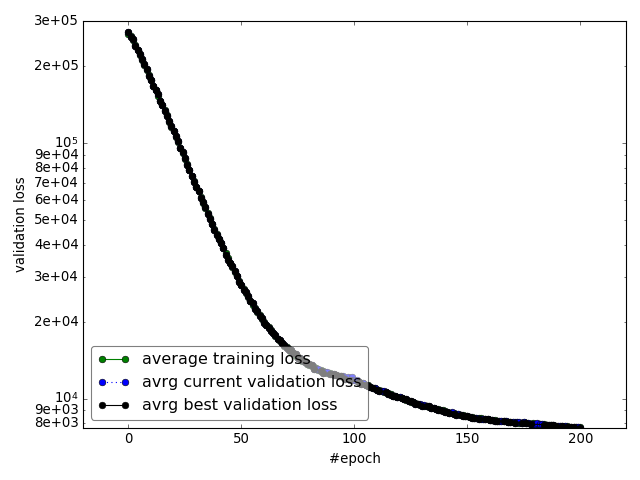

In [30]:
# plot: 
line_train, = plot([], [], 'go-', label="average training loss")
line_curr_val, = plot([],[], 'bo:', label="avrg current validation loss")
line_best_val, = plot([], [], 'ko-', label="avrg best validation loss")
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
yscale('log')
gca().yaxis.set_minor_formatter(FormatStrFormatter("%.2g"))
ylabel("validation loss")
xlabel("#epoch")
legend(loc='lower left', fancybox=True, framealpha=0.5)

# start values:
val_loss = sum(
    optimizer_kwargs['num_loss'](optimizer_kwargs['num_parameters'], vz, vx, no_annealing=True)
    for vz, vx in izip(VZ , VX)
) / len(VZ)
training_loss = sum(
    optimizer_kwargs['num_loss'](optimizer_kwargs['num_parameters'], z, x, no_annealing=True)
    for z, x in izip(Z[:10], X[:10])
) / 10
start_epoch = opt.n_iter//X.shape[0]

add_point(line_best_val, start_epoch, val_loss)
add_point(line_curr_val, start_epoch, val_loss)
add_point(line_train, start_epoch, training_loss)

In [36]:
for info in takeN(hyper.n_epochs, every(X.shape[0], opt)):
    current_epoch = info['n_iter']//X.shape[0]
    # collect and visualize validation loss for choosing the best model
    val_loss = sum(
        optimizer_kwargs['num_loss'](optimizer_kwargs['num_parameters'], vz, vx, no_annealing=True)
        for vz, vx in izip(VZ , VX)
    ) / len(VZ)
    if val_loss < hyper.best_val_loss:
        hyper.best_parameters = opt.wrt
        hyper.best_val_loss = val_loss
        add_point(line_best_val, current_epoch, val_loss)
    hyper.val_loss.append(val_loss)
    add_point(line_curr_val, current_epoch, val_loss)
    
    # visualize training loss for comparison:
    training_loss = sum(
        optimizer_kwargs['num_loss'](optimizer_kwargs['num_parameters'], z, x, no_annealing=True)
        for z, x in izip(Z[:10], X[:10])
    ) / len(Z[:10])
    hyper.train_loss.append(training_loss)
    add_point(line_train, current_epoch, training_loss)
    
#     print info['n_iter'], training_loss, val_loss, best_val_loss

In [32]:
sql_session.add(hyper)
sql_session.commit()

# Performance

TODO: average over predictions

In [33]:
print hyper.best_val_loss
model['flat'] = hyper.best_parameters

predict = predictor.function()
predict(X[0]), Z[0]

11777.1685156
fancy reshaping


(array([-0.04493144]), array([-0.701774], dtype=float32))

In [34]:
PX = np.apply_along_axis(predict, 1, X)
PVX = np.apply_along_axis(predict, 1, VX)
PTX = np.apply_along_axis(predict, 1, TX)

In [35]:
def RMSE(PX, Z):
    return np.sqrt(((PX - Z) ** 2).mean())
def nRMSE(PX, Z):
    return RMSE(PX*Z_std + Z_mean, Z*Z_std + Z_mean)

print '%s RMSE: train/val/test = %g/%g/%g' % (datasetname, nRMSE(PX, Z), nRMSE(PVX, VZ), nRMSE(PTX, TZ))

concrete RMSE: train/val/test = 14.1812/13.9266/16.508
